1. Dataset Overview: Use the IMDB Movie Review Dataset

In [33]:
!pip install kagglehub transformers datasets scikit-learn

import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)



Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


2. Preprocessing: Load and preprocess the dataset suitable for input into DistilBERT and clasical.

  Discuss any data splitting.

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import torch

# Load the dataset
data_path = f"{path}/IMDB Dataset.csv"
df = pd.read_csv(data_path)

# Map sentiment labels to integers
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Print original dataset size
print(f"Original dataset size: {len(df)} reviews")

# Define the size limiter
size_limit = 0.005  # Set this to any fraction (0.1 = 10% of the dataset)

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, stratify=df['sentiment']
)

# Print the size of the train/test split
print("\nDataset was split %80/%20 for training/testing")
print(f"After split: {len(train_texts)} training reviews and {len(test_texts)} test reviews")

# Apply the size limiter for testing (if size_limit < 1.0, reduce the dataset size)
if size_limit < 1.0:
    # Limit the size of training and testing datasets
    train_texts = train_texts[:int(len(train_texts) * size_limit)]
    train_labels = train_labels[:int(len(train_labels) * size_limit)]
    test_texts = test_texts[:int(len(test_texts) * size_limit)]
    test_labels = test_labels[:int(len(test_labels) * size_limit)]

    # Print the reduced dataset size
    print("\nDataset is too large for smallscale testing, so it is reduced for testing.")
    print(f"Reduced dataset size: {len(train_texts)} training reviews and {len(test_texts)} test reviews")

# Tokenization and padding for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

# Save the tokenized data and labels as torch tensors for later use
torch.save(train_encodings, "train_encodings.pt")
torch.save(test_encodings, "test_encodings.pt")
torch.save(torch.tensor(train_labels.values), "train_labels.pt")
torch.save(torch.tensor(test_labels.values), "test_labels.pt")
#print(train_texts.values)
#print(test_texts.values)
#print(train_labels.values)
#print(test_labels.values)
print("Data preprocessing completed and saved.")



Original dataset size: 50000 reviews

Dataset was split %80/%20 for training/testing
After split: 40000 training reviews and 10000 test reviews

Dataset is too large for smallscale testing, so it is reduced for testing.
Reduced dataset size: 200 training reviews and 50 test reviews
Data preprocessing completed and saved.


3. Fine-Tuning DistilBERT: Fine-tune the pre-trained DistilBERT model on the training portion of the IMDB dataset.

  Monitor the training process (e.g., training loss, validation loss).

In [45]:
import torch
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
import logging

# Load the preprocessed data
train_encodings = torch.load("train_encodings.pt")
test_encodings = torch.load("test_encodings.pt")
train_labels = torch.load("train_labels.pt")
test_labels = torch.load("test_labels.pt")

# Create a custom Dataset class
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Prepare datasets
train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Set up logging
logging.basicConfig(level=logging.INFO)  # Set logging level to INFO
logger = logging.getLogger(__name__)

# Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Define training arguments with built-in logging
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",  # Save after every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",  # Log output directory
    logging_steps=10,  # Log every 10 steps
    report_to="tensorboard",  # Enable TensorBoard reporting
    load_best_model_at_end=True,  # Load the best model when training finishes
    evaluation_strategy="epoch",  # Evaluate after each epoch
    logging_first_step=True,  # Log the first step to capture the start of training
)

# Define the Trainer with built-in logging
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Add the metrics computation
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained("fine_tuned_distilbert")
tokenizer.save_pretrained("fine_tuned_distilbert")

# Extract and save accuracy from training logs
train_logs = trainer.state.log_history

# Save the logs for later analysis
with open("training_logs.txt", "w") as f:
    for log in train_logs:
        f.write(str(log) + "\n")

print("Training logs saved as 'training_logs.txt'.")

# After training, print a message
print("Model fine-tuning completed.")


Train dataset size: 200
Test dataset size: 50


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.591900,0.480761,0.820000
2,0.179000,0.544055,0.780000
3,0.048000,0.467841,0.820000


Training logs saved as 'training_logs.txt'.
Model fine-tuning completed.


4. Base Model Comparison: Use the pre-trained DistilBERT model without fine-tuning to classify the test set.

  Compare the results of the fine-tuned DistilBERT with the base model.

In [46]:
import warnings
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch


# Load the pre-trained DistilBERT model and tokenizer (without fine-tuning)
model_base = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the fine-tuned model
fine_tuned_model = DistilBertForSequenceClassification.from_pretrained("fine_tuned_distilbert")

# Function to evaluate model
def evaluate_model(model, test_encodings, test_labels):
    model.eval()  # Set model to evaluation mode
    inputs = torch.tensor(test_encodings['input_ids'])
    attention_mask = torch.tensor(test_encodings['attention_mask'])

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=inputs, attention_mask=attention_mask)

    # Predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Compute accuracy
    correct = (predictions == test_labels).sum().item()
    accuracy = correct / len(test_labels)
    return accuracy

print()
# Evaluate base model (without fine-tuning)
base_accuracy = evaluate_model(model_base, test_encodings, test_labels)
print(f"Base DistilBERT Accuracy: {base_accuracy:.4f}")

# Fine-tuned model is already available from the trainer
fine_tuned_accuracy = evaluate_model(fine_tuned_model, test_encodings, test_labels)
print(f"Fine-tuned DistilBERT Accuracy: {fine_tuned_accuracy:.4f}")

# Compare both the Fine-tuned and Base DistilBERT Accuracy
if fine_tuned_accuracy > base_accuracy:
    print("Fine-tuned DistilBERT performs better than the base model.")
    print(f"Improvement: {fine_tuned_accuracy - base_accuracy:.4f}")
else:
    print("The base model performs better than the fine-tuned model.")
    print(f"Improvement: {base_accuracy - fine_tuned_accuracy:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-46-886f2ce45b0f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(test_encodings['input_ids'])
<ipython-input-46-886f2ce45b0f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(test_encodings['attention_mask'])


Base DistilBERT Accuracy: 0.5600
Fine-tuned DistilBERT Accuracy: 0.8200
Fine-tuned DistilBERT performs better than the base model.
Improvement: 0.2600


5. Classical Machine Learning Model: Train at least one classical machine learning algorithm (e.g., Logistic Regression,
Support Vector Machine, or Random Forest) on the same IMDB dataset, using
TF-IDF features or Bag-of-Words representation.

  Compare its performance with DistilBERT models (base and fine-tuned).

In [47]:
# Logistic Regression for IMDB dataset (using preprocessed data)

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Load preprocessed encodings
train_encodings = torch.load("train_encodings.pt")
test_encodings = torch.load("test_encodings.pt")
train_labels = torch.load("train_labels.pt")
test_labels = torch.load("test_labels.pt")

# Decode tokenized data into raw text for Logistic Regression
def decode_tokens(input_ids_tensor):
    # Convert the tensor to a list and then decode it
    return tokenizer.decode(input_ids_tensor.tolist(), skip_special_tokens=True)

# Decode tokenized data into raw text for Logistic Regression
train_texts = [decode_tokens(input_ids) for input_ids in train_encodings['input_ids']]
test_texts = [decode_tokens(input_ids) for input_ids in test_encodings['input_ids']]

# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_vectors, train_labels)

# Evaluate Logistic Regression model
lr_predictions = lr_model.predict(test_vectors)
lr_accuracy = accuracy_score(test_labels, lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Save the trained model and vectorizer
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Loading and using the saved model for prediction (test code)
def predict_sentiment(texts, model_filename='lr_model.pkl', vectorizer_filename='tfidf_vectorizer.pkl'):
    # Load the saved model and vectorizer
    lr_model = joblib.load(model_filename)
    vectorizer = joblib.load(vectorizer_filename)

    # Convert texts to TF-IDF features
    vectors = vectorizer.transform(texts)

    # Predict sentiment (0: negative, 1: positive)
    predictions = lr_model.predict(vectors)
    return predictions

# Example usage of the prediction function
new_texts = ["I love this movie!", "This was a terrible movie."]
predictions = predict_sentiment(new_texts)
print(f"Predictions: {predictions}")  # Output will be [1, 0] (1: Positive, 0: Negative)


Logistic Regression Accuracy: 0.7600
Predictions: [1 0]


Comparing Linear Regression, Base DistilBERT, and Fine-Tuned DistilBERT accuracy.

In [48]:
import warnings
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Suppress warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Load pre-trained and fine-tuned models
model_base = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
fine_tuned_model = DistilBertForSequenceClassification.from_pretrained("fine_tuned_distilbert")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load preprocessed data
train_encodings = torch.load("train_encodings.pt")
test_encodings = torch.load("test_encodings.pt")
train_labels = torch.load("train_labels.pt")
test_labels = torch.load("test_labels.pt")

# Function to evaluate a model
def evaluate_model(model, test_encodings, test_labels):
    model.eval()
    inputs = torch.tensor(test_encodings['input_ids'])
    attention_mask = torch.tensor(test_encodings['attention_mask'])
    with torch.no_grad():
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct = (predictions == test_labels).sum().item()
    return correct / len(test_labels)

# Evaluate base and fine-tuned DistilBERT models
base_accuracy = evaluate_model(model_base, test_encodings, test_labels)
fine_tuned_accuracy = evaluate_model(fine_tuned_model, test_encodings, test_labels)

# Decode tokenized data into raw text for logistic regression
def decode_tokens(input_ids_tensor):
    return tokenizer.decode(input_ids_tensor.tolist(), skip_special_tokens=True)

train_texts = [decode_tokens(input_ids) for input_ids in train_encodings['input_ids']]
test_texts = [decode_tokens(input_ids) for input_ids in test_encodings['input_ids']]

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

# Logistic regression model training
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_vectors, train_labels)

# Evaluate logistic regression
lr_predictions = lr_model.predict(test_vectors)
lr_accuracy = accuracy_score(test_labels, lr_predictions)

# Save models and vectorizer
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Print comparison results
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Base DistilBERT Accuracy: {base_accuracy:.4f}")
print(f"Fine-tuned DistilBERT Accuracy: {fine_tuned_accuracy:.4f}")

# Compare and determine the best model
if fine_tuned_accuracy > max(base_accuracy, lr_accuracy):
    print("The fine-tuned DistilBERT model performs the best.")
elif base_accuracy > max(fine_tuned_accuracy, lr_accuracy):
    print("The base DistilBERT model performs the best.")
elif lr_accuracy > max(fine_tuned_accuracy, base_accuracy):
    print("The logistic regression model performs the best.")
else:
    print("All models have the same accuracy.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-48-dc79413ac9cf>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(test_encodings['input_ids'])
<ipython-input-48-dc79413ac9cf>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(test_encodings['attention_mask'])


Logistic Regression Accuracy: 0.7600
Base DistilBERT Accuracy: 0.4200
Fine-tuned DistilBERT Accuracy: 0.8200
The fine-tuned DistilBERT model performs the best.


# Analysis and Graphs:
1. Accureacy and Loss Curves: Plot the training and validation accuracy and loss over epochs for the fine-tuned DistilBERT model.


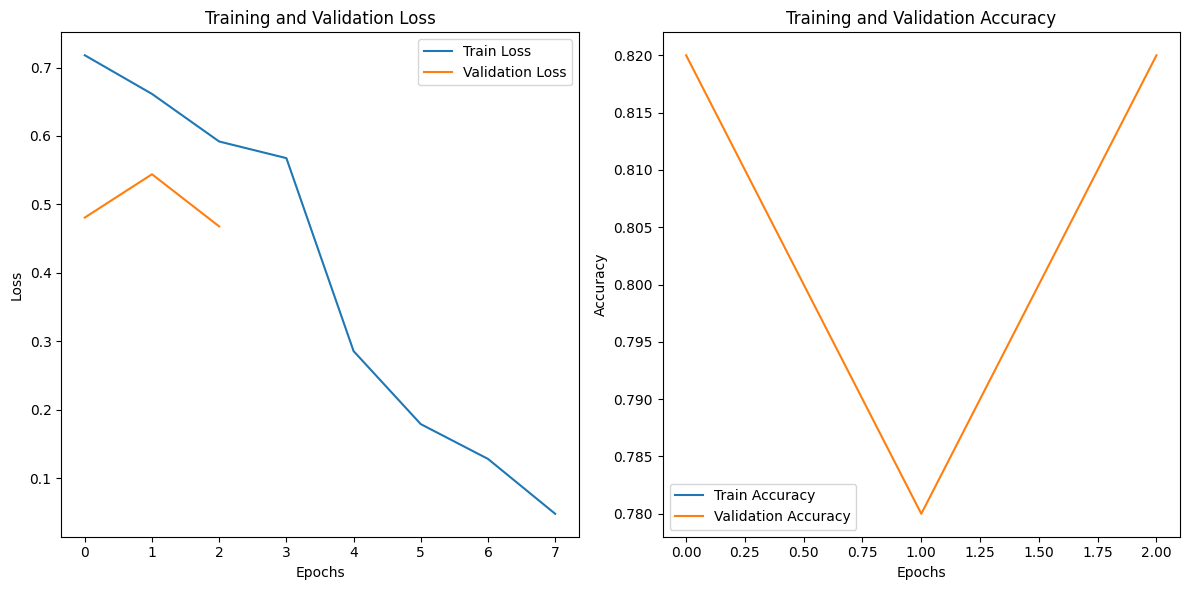

In [49]:
import matplotlib.pyplot as plt

# Extract the training logs (trainer state)
train_logs = trainer.state.log_history

# Initialize lists for storing metrics
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Loop through logs and collect loss and accuracy
for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        val_accuracy.append(log['eval_accuracy'])
    if 'accuracy' in log:
        train_accuracy.append(log['accuracy'])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


2. Confusion Matrix:

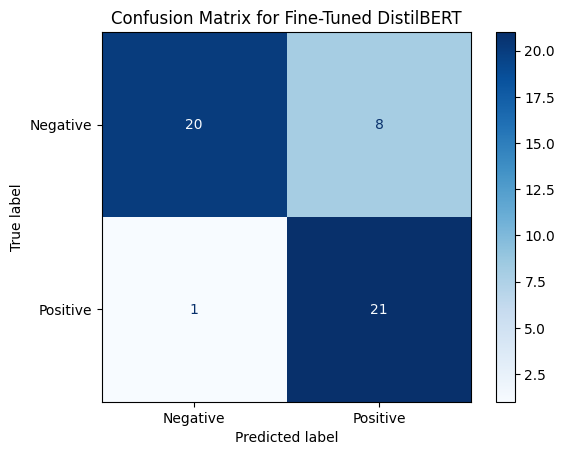

Fine-Tuned Confusion Matrix:
[[20  8]
 [ 1 21]]


In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test dataset
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fine-Tuned DistilBERT")
plt.show()

# Print the confusion matrix
print("Fine-Tuned Confusion Matrix:")
print(cm)


<ipython-input-51-9f517c846237>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(test_encodings['input_ids'])
<ipython-input-51-9f517c846237>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(test_encodings['attention_mask'])


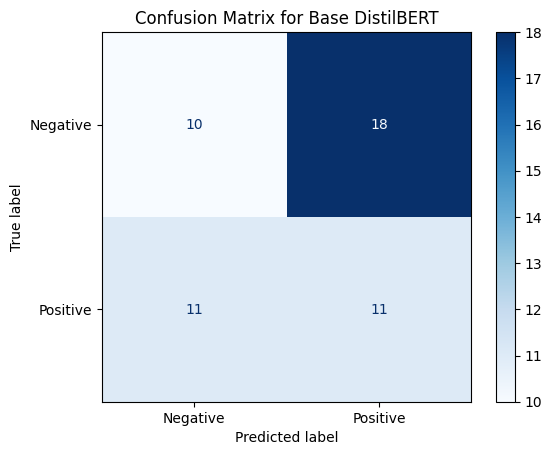

Base Model Confusion Matrix:
[[10 18]
 [11 11]]


In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Function to generate predictions for confusion matrix
def get_predictions(model, test_encodings):
    model.eval()  # Set model to evaluation mode
    inputs = torch.tensor(test_encodings['input_ids'])
    attention_mask = torch.tensor(test_encodings['attention_mask'])

    with torch.no_grad():
        outputs = model(input_ids=inputs, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions

# Generate predictions for base model
base_predictions = get_predictions(model_base, test_encodings)

# Compute confusion matrix for base model
cm_base = confusion_matrix(test_labels, base_predictions)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=["Negative", "Positive"])
disp_base.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Base DistilBERT")
plt.show()


# Print the confusion matrix
print("Base Model Confusion Matrix:")
print(cm_base)


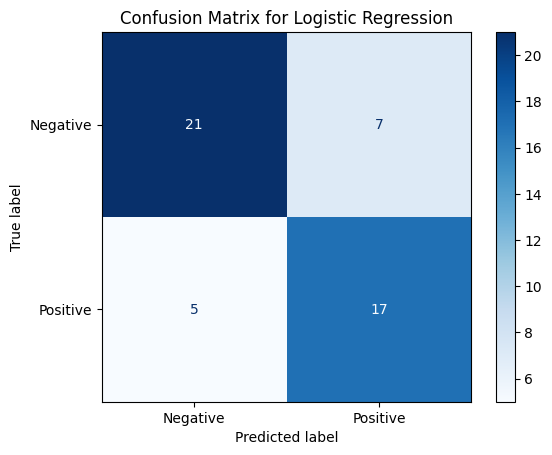

Logistic Regression Confusion Matrix:
[[21  7]
 [ 5 17]]


In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(test_labels, lr_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Print the confusion matrix
print("Logistic Regression Confusion Matrix:")
print(cm)


3. Precision, Recall, and F1-Score: Reporct and compare the precision, recall, and F1-scores of all models.

4. Performance Comparison: Create a comparative table with the evaluation metrics (accuracy, precision, recall, F1-score)

In [53]:
from sklearn.metrics import classification_report
import torch
import numpy as np
from prettytable import PrettyTable

# Define a function to compute metrics with zero_division=0
def compute_metrics(predictions, labels):
    report = classification_report(labels, predictions, target_names=['Negative', 'Positive'], zero_division=0, output_dict=True)
    accuracy = report['accuracy']
    return report, accuracy

# Logistic Regression Metrics
lr_predictions = lr_model.predict(test_vectors)  # Already computed in logistic regression section
lr_report, lr_accuracy = compute_metrics(lr_predictions, test_labels)
print("Logistic Regression Metrics:\n")
print(lr_report)

# Base DistilBERT Model Metrics
model_base.eval()
inputs = test_encodings['input_ids'].clone().detach()
attention_mask = test_encodings['attention_mask'].clone().detach()

with torch.no_grad():
    base_outputs = model_base(input_ids=inputs, attention_mask=attention_mask)

base_predictions = torch.argmax(base_outputs.logits, dim=-1).numpy()
base_report, base_accuracy = compute_metrics(base_predictions, test_labels.numpy())
print("\nBase DistilBERT Metrics:\n")
print(base_report)

# Fine-tuned DistilBERT Model Metrics
fine_tuned_model.eval()

with torch.no_grad():
    fine_tuned_outputs = fine_tuned_model(input_ids=inputs, attention_mask=attention_mask)

fine_tuned_predictions = torch.argmax(fine_tuned_outputs.logits, dim=-1).numpy()
fine_tuned_report, fine_tuned_accuracy = compute_metrics(fine_tuned_predictions, test_labels.numpy())
print("\nFine-tuned DistilBERT Metrics:\n")
print(fine_tuned_report)

# Corrected Summary Comparison Table with Accuracy
def display_comparison(lr_report, base_report, fine_tuned_report, lr_accuracy, base_accuracy, fine_tuned_accuracy):
    def parse_report(report):
        # Extract precision, recall, and f1-score for both Negative and Positive classes
        metrics = {}
        for label in ['Negative', 'Positive']:
            if label in report:
                metrics[label] = {
                    'Precision': report[label]['precision'],
                    'Recall': report[label]['recall'],
                    'F1-Score': report[label]['f1-score']
                }
        return metrics

    # Get reports for each model
    lr_metrics = parse_report(lr_report)
    base_metrics = parse_report(base_report)
    fine_tuned_metrics = parse_report(fine_tuned_report)

    # Create and display table with Accuracy, Precision, Recall, and F1-score
    table = PrettyTable()
    table.field_names = ["Model", "Accuracy", "Precision (Avg)", "Recall (Avg)", "F1-Score (Avg)"]

    table.add_row([
        "Logistic Regression",
        round(lr_accuracy, 4),
        round(lr_metrics['Positive']['Precision'], 4),
        round(lr_metrics['Positive']['Recall'], 4),
        round(lr_metrics['Positive']['F1-Score'], 4)
    ])
    table.add_row([
        "Base DistilBERT",
        round(base_accuracy, 4),
        round(base_metrics['Positive']['Precision'], 4),
        round(base_metrics['Positive']['Recall'], 4),
        round(base_metrics['Positive']['F1-Score'], 4)
    ])
    table.add_row([
        "Fine-tuned DistilBERT",
        round(fine_tuned_accuracy, 4),
        round(fine_tuned_metrics['Positive']['Precision'], 4),
        round(fine_tuned_metrics['Positive']['Recall'], 4),
        round(fine_tuned_metrics['Positive']['F1-Score'], 4)
    ])

    print("\nModel Comparison:\n")
    print(table)

display_comparison(lr_report, base_report, fine_tuned_report, lr_accuracy, base_accuracy, fine_tuned_accuracy)


Logistic Regression Metrics:

{'Negative': {'precision': 0.8076923076923077, 'recall': 0.75, 'f1-score': 0.7777777777777778, 'support': 28.0}, 'Positive': {'precision': 0.7083333333333334, 'recall': 0.7727272727272727, 'f1-score': 0.7391304347826086, 'support': 22.0}, 'accuracy': 0.76, 'macro avg': {'precision': 0.7580128205128205, 'recall': 0.7613636363636364, 'f1-score': 0.7584541062801933, 'support': 50.0}, 'weighted avg': {'precision': 0.763974358974359, 'recall': 0.76, 'f1-score': 0.7607729468599034, 'support': 50.0}}

Base DistilBERT Metrics:

{'Negative': {'precision': 0.47619047619047616, 'recall': 0.35714285714285715, 'f1-score': 0.40816326530612246, 'support': 28.0}, 'Positive': {'precision': 0.3793103448275862, 'recall': 0.5, 'f1-score': 0.43137254901960786, 'support': 22.0}, 'accuracy': 0.42, 'macro avg': {'precision': 0.4277504105090312, 'recall': 0.4285714285714286, 'f1-score': 0.41976790716286516, 'support': 50.0}, 'weighted avg': {'precision': 0.4335632183908046, 'recal